##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Post-Training Integer Static Quantization : CIFAR-10 
## + Autres stratégies post-entrainement

Ce notebook est un dérivé du notebook tutoriel créé directement par Tensor Flow. 
La source est disponible ci-dessous :

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_integer_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Synthèse

La quantification des nombres entiers est une stratégie d'optimisation qui convertit les nombres à virgule flottante de 32 bits (tels que les poids et les sorties d'activation) en nombres à virgule fixe de 8 bits les plus proches. Il en résulte un modèle plus petit et une vitesse d'inférence accrue, ce qui est précieux pour les dispositifs à faible consommation d'énergie tels que les [microcontrôleurs](https://www.tensorflow.org/lite/microcontrollers). Ce format de données est également requis par les accélérateurs à nombres entiers uniquement, tels que l'[Edge TPU](https://coral.ai/).


Dans ce tutoriel, vous allez entraîner un modèle CIFAR-10 à partir de zéro, le convertir en un fichier Tensorflow Lite, et le quantifier en utilisant [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). Enfin, vous vérifierez la précision du modèle converti et le comparerez au modèle flottant original.


Vous disposez en fait de plusieurs options pour quantifier un modèle. Dans ce tutoriel, vous effectuerez notamment une "quantification intégrale", qui convertit tous les poids et toutes les sorties d'activation en données entières de 8 bits, alors que d'autres stratégies peuvent laisser une certaine quantité de données en virgule flottante.
En plus de cela, vous créérez aussi des modèles quantifés dynamiquement et en float16 mais de façon plus brève.


Pour en savoir plus sur les différentes stratégies de quantification, lisez [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization).

## Objectif

L'objectif de ce hands-on est de créer un modèle, de l'entrainer, de le quantifier, de comparer les performances entre le modèle classique et quantifié et de comparer leurs émissions CO2eq pour l'inférence.

Le déroulement se fait donc en 3 grandes étapes :
1. Contruction d'un modèle pour CIFAR-10
2. Conversion et quantification du modèle
3. Comparaison des modèles TFLite

## Dataset

Le dataset utilisé pour ce notebook est le célèbre CIFAR (Canadian Institute For Advanced Research), composé d'images de 10 classes (d'où le CIFAR-10, il existe aussi le CIFAR-100 pour plus de classes). Les catégories d'images sont :
- avions
- voitures
- oiseaux
- chats
- cerfs
- chiens
- grenouilles
- chevaux
- bateaux
- camions

Le dataset contient 50000 images d'entrainement et 10000 de test, donc au total 6000 images par classe. Les images sont de taille 32x32.

[Wikipédia CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10)

<img src="https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png">

## Construction d'un modèle pour CIFAR-10

### Préparation

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib
from keras import layers
from keras import models
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.mobilenet import MobileNet
import matplotlib.pyplot as plt

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras import optimizers
from keras.layers import Resizing
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D, BatchNormalization,LayerNormalization

from typing import Callable

### Entrainement du modèle Tensor Flow

<a id='simple_cifar_model'></a>

Tout d'abord, on commence par créer une fonction _mobile_net_for_cifar10_ pour définir notre modèle séquentiel.

En plus de la quantification, nous allons utiliser du Transfer Learning pour faire converger notre modèle plus rapidement. Le dataset ImageNet est constitué d'images de 1000 classes diverses et variées et dont certaines sont (ou se rapprochent) de nos classes objectifs avec CIFAR-10. Il est donc pertinent de partir d'un modèle pré-entrainé sur ces données.

Le modèle est composé d'un modèle MobileNet pré-entrainé sur les données ImageNet auquel on a remplacé la couche de MLP finale par une nouvelle couche de MLP personnalisée. En amont de ce modèle, nous devons placer une couche de redimensionnement des images car les modèles pré-entrainés sur ImageNet peuvent prendre en entrer des images carrés soit en 128, 160, 192 ou 224 pixels de côté. 

Nous prenons le modèle en 224 pixels car c'est celui avec la meilleure précision avec 70,6%. Les précisions en fonction des différentes tailles sont disponibles dans la [documentation tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet).

In [2]:
INPUT_IMG_SIZE = 224

def mobile_net_for_cifar10():
    # Base model for the mobilenet model
    mobnet_model = MobileNet(weights='imagenet',include_top=False,
                            input_shape=(INPUT_IMG_SIZE,INPUT_IMG_SIZE,3)) 
    #imports the mobilenet model and discards the last 1000 neuron layer.
    
    image_size = (INPUT_IMG_SIZE,INPUT_IMG_SIZE)

    model = Sequential()
    
    model.add(keras.layers.Input(shape=(32,32,3)))
    model.add(keras.layers.Resizing(image_size[0], image_size[1], interpolation="bilinear"))

    model.add(mobnet_model) 
    model.add(GlobalAveragePooling2D())

    #model.add(Dense(1024,activation=('relu')))
    #model.add(Dense(512,activation=('relu'))) 
    #model.add(Dense(256,activation=('relu'))) 
    #model.add(Dropout(0.5))
    #model.add(Dense(128,activation=('relu')))
    #model.add(Dropout(0.5))
    model.add(Dense(10,activation=('softmax')))

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer= 'Adam',
                metrics=['accuracy'])
    
    return model

Il nous faut après charger les données du dataset CIFAR-10, directement avec Keras.

<div class="alert alert-block alert-info"><b>Note:</b> Plusieurs datasets sont directements accessibles avec le module <a href="https://www.tensorflow.org/api_docs/python/tf/keras/datasets">keras.datasets</a> (documentation Tensor Flow). <br>
&emsp;&emsp;&emsp; La liste est aussi disponible sur la <a href="https://keras.io/api/datasets/">documentation de l'API Keras.</a></div>

In [3]:
# Load CIFAR-10 dataset
cifar10 = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

Nous séparons ensuite le dataset d'entrainement pour avoir un ensemble de validation en plus, et nous limitons à 10000 le nombre d'exemples de tests pour que les comparaisons (plus tard) se fassent dans un temps raisonnable.

In [4]:
x_test, y_test = test_images[:10000], test_labels[:10000]
x_train, y_train = train_images, train_labels

Enfin, il nous reste à définir le modèle avec la [fonction créée ci-dessus](#simple_cifar_model).

Nous pouvons ainsi avoir un résumé de notre modèle par couche (bien que le MobileNet soit condensé en une couche alors qu'en réalité il s'agit de nombreuses couches), ainsi que le nombre de paramètres fixes ou à entraîner. Nous aurions également pu, si nous le souhaitions, figer le MobileNet pour n'entrainer que le MLP final (c'est une stratégie différente de Transfer Learning) alors qu'ici nous continuons à en entrainer ses poids.

In [5]:
# Define the model architecture
model = mobile_net_for_cifar10()
model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                10250     
                                                                 
Total params: 3,239,114
Trainable params: 3,217,226
Non-trainable params: 21,888
_________________________________________________________________


Si vous avez déjà entrainé un modèle avec cette architecture, vous pouvez en charger les poids ici et directement passer à la [__conversion du modèle__](#quantify_model).

In [6]:
model.load_weights("cifar10_mobilenet_ptq_int8_891.h5")
model.evaluate(x_test, y_test)

2023-06-07 16:08:53.749354: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 [==============================] - 15s 47ms/step - loss: 0.3284 - accuracy: 0.8908


[0.32835569977760315, 0.8907999992370605]

Nous allons également définir un _callback_ EarlyStopping pour arrêter l'entrainement en cas de surapprentissage.

In [7]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10,
                                     restore_best_weights=True)

Il nous reste à l'entrainer. Nous commençons par 3 epochs.

In [8]:
history = model.fit(x_train, y_train, batch_size=32, steps_per_epoch=100, 
                    epochs=50, validation_split=0.2, callbacks=[es])

Epoch 1/50


2023-06-06 15:19:56.030798: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


100/100 [==============================] - 32s 303ms/step - loss: 1.1167 - accuracy: 0.6553 - val_loss: 2.8866 - val_accuracy: 0.4564
Epoch 2/50
100/100 [==============================] - 29s 296ms/step - loss: 0.7729 - accuracy: 0.7412 - val_loss: 2.3914 - val_accuracy: 0.5059
Epoch 3/50
100/100 [==============================] - 29s 296ms/step - loss: 0.6322 - accuracy: 0.7891 - val_loss: 1.5907 - val_accuracy: 0.6433
Epoch 4/50
100/100 [==============================] - 30s 303ms/step - loss: 0.5401 - accuracy: 0.8231 - val_loss: 1.0087 - val_accuracy: 0.6813
Epoch 5/50
100/100 [==============================] - 30s 301ms/step - loss: 0.5090 - accuracy: 0.8319 - val_loss: 1.1127 - val_accuracy: 0.6885
Epoch 6/50
100/100 [==============================] - 30s 300ms/step - loss: 0.5048 - accuracy: 0.8300 - val_loss: 1.4472 - val_accuracy: 0.6246
Epoch 7/50
100/100 [==============================] - 30s 301ms/step - loss: 0.4595 - accuracy: 0.8422 - val_loss: 0.9195 - val_accuracy: 0.7

Pour cet exemple, comme nous avons entrainé sur 50 epochs de 3200 images chacune seulement, pour avoir une validation plus régulière, et nous obtenons une performance tout à fait correcte en validation.

Nous pouvons visualier l'évolution de la _loss_ d'entrainenment (Training) et de validation (Validation) sur ce graph.

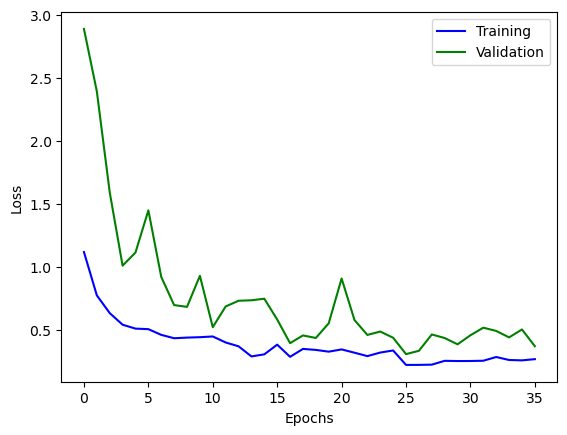

In [9]:
plt.plot(history.epoch, history.history["loss"], 'b', label='Training')
plt.plot(history.epoch, history.history["val_loss"], 'g', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

On voit ainsi que nous étions en "descente" pure des courbes de _loss_. Nous aurions donc sans doute pû entrainer le modèle pour plus d'epochs sans qu'il sur-entraîne.

Nous allons sauvegarder les poids de ce modèle "float" pour les réutiliser dans d'autres notebooks de comparaisons de modèles.

In [10]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 15s 48ms/step - loss: 0.3284 - accuracy: 0.8908


[0.32835569977760315, 0.8907999992370605]

In [11]:
model.save_weights("cifar10_mobilenet_ptq_int8_891.h5")

<a id='quantify_model'></a>

## Conversion et quantification du modèle

### Conversition en modèle TensorFlow Lite

En utilisant le convertisseur de TensorFlow Lite, [Converter](https://www.tensorflow.org/lite/models/convert), il est facilement possible de convertir le modèle entraîné en modèle TensorFlow Lite.

Chargeons maintenant le modèle en utilisant `TFLiteConverter`:

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpy75lnif6/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpy75lnif6/assets
2023-06-07 16:09:42.723583: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-07 16:09:42.723602: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


Nous pouvons maintenant enregistrer ce modèle de base.

In [8]:
tflite_models_dir = pathlib.Path("/tmp/cifar10_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [9]:
tflite_model_file = tflite_models_dir/"cifar10_model.tflite"
tflite_model_file.write_bytes(tflite_model)

12845520

Nous avons donc une taille d'environ 13 Mb.

### Exemple de quantification de valeurs

In [10]:
tf.quantization.quantize(3.1415986,-10,10,"qint8").output

Instructions for updating:
`tf.quantize_v2` is deprecated, please use `tf.quantization.quantize` instead.


Instructions for updating:
`tf.quantize_v2` is deprecated, please use `tf.quantization.quantize` instead.


<tf.Tensor: shape=(), dtype=qint8, numpy=40>

In [11]:
tf.quantization.quantize(3.1415986,-100,100,"qint8").output

<tf.Tensor: shape=(), dtype=qint8, numpy=4>

In [12]:
tf.quantization.quantize(3.1415986,-1000,1000,"qint8").output

<tf.Tensor: shape=(), dtype=qint8, numpy=0>

In [13]:
tf.quantization.quantize(3.1415986,-4,4,"qint8").output

<tf.Tensor: shape=(), dtype=qint8, numpy=100>

### Quantification du modèle en Integer8

Pour quantifier les données variables (telles que les entrées/sorties du modèle et les intermédiaires entre les couches), vous devez fournir un [`RepresentativeDataset`](https://www.tensorflow.org/api_docs/python/tf/lite/RepresentativeDataset). Il s'agit d'une fonction génératrice qui fournit un ensemble de données d'entrée suffisamment important pour représenter des valeurs typiques. Elle permet au convertisseur d'estimer une plage dynamique pour toutes les données variables. (Il n'est pas nécessaire que l'ensemble de données soit unique par rapport à l'ensemble de données d'apprentissage ou d'évaluation).

Pour prendre en charge des entrées multiples, chaque point de données représentatif est une liste et les éléments de la liste sont transmis au modèle en fonction de leurs indices.

In [14]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        # Model has only one input so each data point has one element.
        yield [tf.cast(input_value, tf.float32)]

Nous allons ensuite utiliser le flag par défault de `optimizations` pour quantifier l'intégralité des paramètres fixes (poids etc.). 
Puis nous allons donner le générateur de données représentatives aux convertisseur, avant d'enregistrer le modèle.

<div class="alert alert-block alert-warning">
        <b>Attention:</b> Si on ne fournit pas de dataset représentatif au convertisseur, <b>avec le flag par défaut d'optimisation</b>, la quantification appliquée serait une de la plage dynamique et non en entier statiques.
</div>

In [15]:
converter_quant = tf.lite.TFLiteConverter.from_keras_model(model)
converter_quant.optimizations = [tf.lite.Optimize.DEFAULT]
converter_quant.representative_dataset = representative_data_gen # For full integer static quantization

tflite_model_quant = converter_quant.convert()

INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpliqcqghu/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpliqcqghu/assets
/Users/axel.de.labriffe/miniforge3/envs/tensorflow-v3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-07 16:10:47.001232: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-07 16:10:47.001247: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


Pour maintenir la compatibilité avec les applications qui utilisent traditionnellement des tenseurs d'entrée et de sortie de modèle en float, le convertisseur TensorFlow Lite laisse les tenseurs d'entrée et de sortie de modèle en float.

In [16]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


Pour quantifier les tenseurs d'entrée et de sortie et faire en sorte que le convertisseur envoie une erreur s'il rencontre une opération qu'il ne peut pas quantifier, convertissez à nouveau le modèle avec quelques paramètres supplémentaires.

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmp7pl3837c/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmp7pl3837c/assets
/Users/axel.de.labriffe/miniforge3/envs/tensorflow-v3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-07 16:11:05.780888: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-07 16:11:05.780902: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


La quantification interne reste la même que ci-dessus, mais vous pouvez voir que les tenseurs d'entrée et de sortie sont maintenant au format entier aussi.

In [18]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Enfin, on peux enregistrer notre modèle quantifié.

In [19]:
tflite_model_quant_file = tflite_models_dir/"cifar10_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

3525072

In [20]:
!ls -lh {tflite_models_dir}

total 90312
-rw-r--r--  1 axel.de.labriffe  wheel    12M  7 jui 16:09 cifar10_model.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   3,4M  7 jui 16:11 cifar10_model_quant.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   6,1M  7 jui 12:40 cifar10_qat_f16.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   3,4M  7 jui 11:52 cifar10_qat_f16_cold.tflite
-rw-r--r--  1 axel.de.labriffe  wheel    12M  7 jui 11:00 cifar10_qat_float.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   3,4M  7 jui 11:01 cifar10_qat_int_cold.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   3,4M  7 jui 11:01 cifar10_qat_int_warm.tflite


Notons que le fichier de sortie ne fait environ que `1/4` de la taille du modèle originel.

### Généralisation de la quantification

Finalement, pour les différentes quantifications post-entrainement, nous pouvons écrire une fonction générale _post_training_quantization_, qui groupera en une fonction les différents types de quantification post-entrainement.

In [21]:
from typing import Callable

In [22]:
def post_training_quantization(model: tf.keras.Model, q_type: str, 
                               representative_data_gen: Callable = None, 
                               io_type: str = "keep_default"):
    if not isinstance(model, tf.keras.Model):
        raise TypeError("'model' seem not to be a tf.keras.Model.")
    if not isinstance(q_type, str):
        raise TypeError("'q_type' seem not to be a string")
    if q_type not in ("int8", "float16", "dynamic"):
        raise ValueError("Unknown q_type inserted. 'q_type' should be 'int8', 'float16' or 'dynamic'.")
    if not isinstance(io_type, str):
        raise TypeError("'io_type' seem not to be a string")
    if io_type not in ("same", "keep_default"):
        raise TypeError("Unknown 'io_type' inserted. io_type should be 'same' or 'keep_default'.")
    
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    if q_type == "int8":
        if representative_data_gen is None:
            raise ValueError("""For full integer quantization, a representative dataset should be passed as the 
                             'representative_data_gen' argument. Got None.""")
        if not isinstance(representative_data_gen, Callable):
            raise TypeError("'representative_data_gen' needs to be a callable function (generator).")
            
        converter.representative_dataset = representative_data_gen
        print("Quantifying model : Full Integer8 quantization.")
        
        if io_type == 'same':
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            # Set the input and output tensors to uint8 (APIs added in r2.3)
            converter.inference_input_type = tf.uint8
            converter.inference_output_type = tf.uint8
            print("IO Type : Integer8")
        else:
            print("IO Type : Keep default (float32).")
            
    elif q_type == "float16":
        converter.target_spec.supported_types = [tf.float16]
        print("Quantifying model : Float16 quantization.")
    else:
        print("Quantifying model : Dynamic quantization.")
        
    tflite_model_quant = converter.convert()
    return tflite_model_quant

Ensuite nous pouvons ainsi créer un modèle quantifié lui en float16. Les paramètres seront quantifiés en float16, mais le modèle s'executera avec des opérations en float32. __C'est la seule stratégie (à priori) compatible avec les GPUs.__

In [23]:
tflite_model_quant_f16 = post_training_quantization(model, q_type="float16", 
                                                    io_type="keep_default")
tflite_model_quant_f16_file = tflite_models_dir/"cifar10_ptq_f16.tflite"
tflite_model_quant_f16_file.write_bytes(tflite_model_quant_f16)

Quantifying model : Float16 quantization.


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpxnfhl3ua/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpxnfhl3ua/assets
2023-06-07 16:11:25.228914: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-07 16:11:25.228937: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


6442668

Ainsi qu'un autre quantifié dynamiquement, où ici les paramètres sont quantifiés en integer et le modèle s'éxécute avec un mix d'opérations entières ou flotantes lorsque cela est possible, et si le mix n'est pas possible "retombe" alors sur des calculs en float32.

Cependant, les outputs sont toujours stockés en float, ainsi l'augmentation de la vitesse en quantification dynamique est inférieure à celle d'une quantification statique (vers int8 par exemple).

In [24]:
tflite_model_quant_dyn = post_training_quantization(model, q_type="dynamic", 
                                                    io_type="keep_default")
tflite_model_quant_dyn_file = tflite_models_dir/"cifar10_ptq_dynamic.tflite"
tflite_model_quant_dyn_file.write_bytes(tflite_model_quant_dyn)

Quantifying model : Dynamic quantization.


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpe9mzugn5/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpe9mzugn5/assets
2023-06-07 16:11:32.329620: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-07 16:11:32.329640: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


3395152

## Comparaison des modèles TFLite

Nous allons lancer les modèles TensorFlow Lite en utilisant l'interpreteur Python de TensorFlow Lite
`Interpreter`.

### Test du modèle sur une image

Nous allons maintenant exécuter des inférences en utilisant TensorFlow Lite [`Interpreter`] (https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) pour comparer la précision des modèles.


Tout d'abord, nous avons besoin d'une fonction qui exécute l'inférence avec un modèle et des images donnés (ici nos images de test), puis renvoie les prédictions.

In [25]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global test_images

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_images[test_image_index]
        test_label = test_labels[test_image_index]

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax()

    return predictions

Créons une autre fonction pour imprimer nos prédictions.

In [26]:
import matplotlib.pylab as plt

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
    global test_labels

    predictions = run_tflite_model(tflite_file, [test_image_index])

    plt.imshow(test_images[test_image_index])
    template = model_type + " Model \n True:{true}, Predicted:{predict}"
    _ = plt.title(template.format(true= str(test_labels[test_image_index][0]), 
                                  predict=str(predictions[0])))
    plt.grid(False)

Puis faisons un test pour le modèle Float :

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


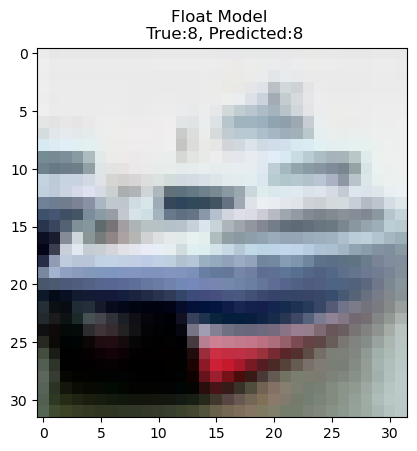

In [27]:
# Change this to test a different image
test_image_index = 1
test_model(tflite_model_file, test_image_index, model_type="Float")

Puis pour le modèle Quantifié :

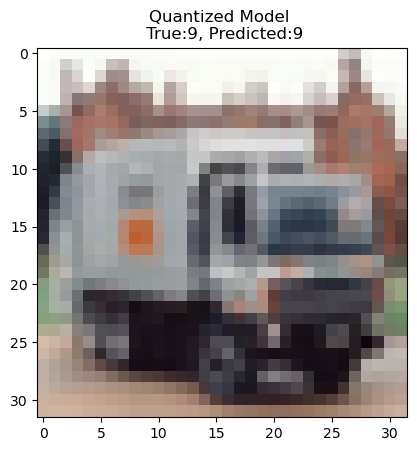

In [28]:
test_image_index = 11
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

### Evaluation des modèles

Nous allons maintenant comparer les performances du modèle flottant et du modèle quantifié :

+ `tflite_model_file` est le modèle TensorFlow Lite original avec des données en virgule flottante.

+ `tflite_model_quant_file` est le dernier modèle que nous avons converti en utilisant la quantification des entiers seulement (il utilise des données uint8 pour l'entrée et la sortie).

In [29]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
    global test_images
    global test_labels

    test_image_indices = range(test_images.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)

    accuracy = (np.sum(test_labels.flatten()==predictions) * 100) / len(test_images)

    print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

Nous allons donc tester ces modèles sur le dataset de test, plusieurs fois pour obtenir un temps moyen.

In [30]:
%%timeit -r 3 -n 1
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 89.0800% (Number of test samples=10000)
Float model accuracy is 89.0800% (Number of test samples=10000)
Float model accuracy is 89.0800% (Number of test samples=10000)
2min 45s ± 84 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [31]:
%%timeit -r 3 -n 1
evaluate_model(tflite_model_quant_file, model_type="Quantized Int8")

Quantized Int8 model accuracy is 87.2800% (Number of test samples=10000)
Quantized Int8 model accuracy is 87.2800% (Number of test samples=10000)
Quantized Int8 model accuracy is 87.2800% (Number of test samples=10000)
41.8 s ± 80.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


On constate ici que le gain en temps d'inférence est conséquent, avec une division par 4 (environ).

Voyons voir ce qu'il en est des autres stratégies moins radicales de quantification, avec en float16 puis la dynamique.

In [32]:
%%timeit -r 3 -n 1
evaluate_model(tflite_model_quant_f16_file, model_type="Quantized Float16")

Quantized Float16 model accuracy is 89.0500% (Number of test samples=10000)
Quantized Float16 model accuracy is 89.0500% (Number of test samples=10000)
Quantized Float16 model accuracy is 89.0500% (Number of test samples=10000)
2min 45s ± 132 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [33]:
%%timeit -r 3 -n 1
evaluate_model(tflite_model_quant_dyn_file, model_type="Quantized Dynamic")

Quantized Dynamic model accuracy is 89.0800% (Number of test samples=10000)
Quantized Dynamic model accuracy is 89.0800% (Number of test samples=10000)
Quantized Dynamic model accuracy is 89.0800% (Number of test samples=10000)
1min 3s ± 165 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


### Evaluation Code Carbon

Nous allons maintenant faire une comparaison via la librairie Code Carbon qui permet d'estimer l'impact carbone d'un code en prenant en compte le CPU, la RAM etc.

Pour plus d'informations, visitez la [documentation officielle](https://mlco2.github.io/codecarbon/).

In [34]:
!pip install codecarbon

Nous allons utiliser _EmissionsTracker_ qui nous donnera des informations de consommations et les enregistrera aussi dans un fichier csv.

In [35]:
from codecarbon import EmissionsTracker

Puis comparons, pour une évaluation (donc 10000 inférences) la différence d'energie en kWh utilisé.
Commençons par le modèle classic Float.

In [36]:
with EmissionsTracker() as tracker:
    evaluate_model(tflite_model_file, model_type="Float")

[codecarbon INFO @ 16:34:30] [setup] RAM Tracking...
[codecarbon INFO @ 16:34:30] [setup] GPU Tracking...
[codecarbon INFO @ 16:34:30] No GPU found.
[codecarbon INFO @ 16:34:30] [setup] CPU Tracking...
[codecarbon WARNING @ 16:34:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:34:30] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 16:34:30] >>> Tracker's metadata:
[codecarbon INFO @ 16:34:30]   Platform system: macOS-13.4-arm64-arm-64bit
[codecarbon INFO @ 16:34:30]   Python version: 3.9.16
[codecarbon INFO @ 16:34:30]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 16:34:30]   Available RAM : 32.000 GB
[codecarbon INFO @ 16:34:30]   CPU count: 10
[codecarbon INFO @ 16:34:30]   CPU model: Apple M1 Pro
[codecarbon INFO @ 16:34:30]   GPU count: None
[codecarbon INFO @ 16:34:30]   GPU model: None
[codecarbon INFO @ 16:34:48] Energy consumed for RAM : 0.000050 kWh. RAM Power : 12.0 W
[codecarbon INFO @ 16:34:48] Energy consume

Float model accuracy is 89.0800% (Number of test samples=10000)


Puis le modèle Quantifié.

In [37]:
with EmissionsTracker() as tracker:
    evaluate_model(tflite_model_quant_file, model_type="Quantized Int8")

[codecarbon INFO @ 16:37:19] [setup] RAM Tracking...
[codecarbon INFO @ 16:37:19] [setup] GPU Tracking...
[codecarbon INFO @ 16:37:19] No GPU found.
[codecarbon INFO @ 16:37:19] [setup] CPU Tracking...
[codecarbon WARNING @ 16:37:19] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:37:19] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 16:37:19] >>> Tracker's metadata:
[codecarbon INFO @ 16:37:19]   Platform system: macOS-13.4-arm64-arm-64bit
[codecarbon INFO @ 16:37:19]   Python version: 3.9.16
[codecarbon INFO @ 16:37:19]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 16:37:19]   Available RAM : 32.000 GB
[codecarbon INFO @ 16:37:19]   CPU count: 10
[codecarbon INFO @ 16:37:19]   CPU model: Apple M1 Pro
[codecarbon INFO @ 16:37:19]   GPU count: None
[codecarbon INFO @ 16:37:19]   GPU model: None
[codecarbon INFO @ 16:37:35] Energy consumed for RAM : 0.000050 kWh. RAM Power : 12.0 W
[codecarbon INFO @ 16:37:35] Energy consume

Quantized Int8 model accuracy is 87.2800% (Number of test samples=10000)


Dans cet exemple, on voit ainsi que l'énergie consommé est environ 4 fois inférieure pour le modèle quantifié en int8!

Voyons voir pour les stratégies moins radicales.

In [38]:
with EmissionsTracker() as tracker:
    evaluate_model(tflite_model_quant_f16_file, model_type="Quantized Float16")

[codecarbon INFO @ 16:38:03] [setup] RAM Tracking...
[codecarbon INFO @ 16:38:03] [setup] GPU Tracking...
[codecarbon INFO @ 16:38:03] No GPU found.
[codecarbon INFO @ 16:38:03] [setup] CPU Tracking...
[codecarbon WARNING @ 16:38:03] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:38:03] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 16:38:03] >>> Tracker's metadata:
[codecarbon INFO @ 16:38:03]   Platform system: macOS-13.4-arm64-arm-64bit
[codecarbon INFO @ 16:38:03]   Python version: 3.9.16
[codecarbon INFO @ 16:38:03]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 16:38:03]   Available RAM : 32.000 GB
[codecarbon INFO @ 16:38:03]   CPU count: 10
[codecarbon INFO @ 16:38:03]   CPU model: Apple M1 Pro
[codecarbon INFO @ 16:38:03]   GPU count: None
[codecarbon INFO @ 16:38:03]   GPU model: None
[codecarbon INFO @ 16:38:22] Energy consumed for RAM : 0.000050 kWh. RAM Power : 12.0 W
[codecarbon INFO @ 16:38:22] Energy consume

Quantized Float16 model accuracy is 89.0500% (Number of test samples=10000)


In [39]:
with EmissionsTracker() as tracker:
    evaluate_model(tflite_model_quant_dyn_file, model_type="Quantized Dynamic")

[codecarbon INFO @ 16:40:55] [setup] RAM Tracking...
[codecarbon INFO @ 16:40:55] [setup] GPU Tracking...
[codecarbon INFO @ 16:40:55] No GPU found.
[codecarbon INFO @ 16:40:55] [setup] CPU Tracking...
[codecarbon WARNING @ 16:40:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:40:55] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 16:40:55] >>> Tracker's metadata:
[codecarbon INFO @ 16:40:55]   Platform system: macOS-13.4-arm64-arm-64bit
[codecarbon INFO @ 16:40:55]   Python version: 3.9.16
[codecarbon INFO @ 16:40:55]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 16:40:55]   Available RAM : 32.000 GB
[codecarbon INFO @ 16:40:55]   CPU count: 10
[codecarbon INFO @ 16:40:55]   CPU model: Apple M1 Pro
[codecarbon INFO @ 16:40:55]   GPU count: None
[codecarbon INFO @ 16:40:55]   GPU model: None
[codecarbon INFO @ 16:41:11] Energy consumed for RAM : 0.000050 kWh. RAM Power : 12.0 W
[codecarbon INFO @ 16:41:11] Energy consume

Quantized Dynamic model accuracy is 89.0800% (Number of test samples=10000)


## Bonus : optimiser un modèle existant

Nous pouvons prendre un modèle "tout prêt" et le quantifier. Par exemple, ici un modèle ResNet101 avec les poids ImageNet.

In [40]:
resnet_v2_101 = tf.keras.applications.ResNet101(weights="imagenet")

converter = tf.lite.TFLiteConverter.from_keras_model(resnet_v2_101)

Puis enregistrons ce modèle de base.

In [41]:
# Convert to TF Lite without quantization
resnet_tflite_file = tflite_models_dir/"resnet_v2_101.tflite"
resnet_tflite_file.write_bytes(converter.convert())

INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmphjtfnrjy/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmphjtfnrjy/assets
2023-06-07 16:42:25.748813: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-07 16:42:25.748830: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


178055132

En fonction des données disponibles, plusieurs stratégies de quantification sont possibles. Ici, nous n'avons pas de données représentatives (à moins de télécharger une partie du dataset ImageNet) donc nous ne pouvons pas quantifier en integer comme dans le tutoriel plus haut.

En revanche, **même sans ces données** nous pouvons quand même quantifier les poids en float16 et l'enregistrer.

In [42]:
# Convert to TF Lite with quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

resnet_quantized_tflite_file = tflite_models_dir/"resnet_v2_101_quantized.tflite"
resnet_quantized_tflite_file.write_bytes(converter.convert())

INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpi050a0wk/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpi050a0wk/assets
2023-06-07 16:42:52.373683: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-07 16:42:52.373706: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


89091220

In [43]:
!ls -lh {tflite_models_dir}/*.tflite

-rw-r--r--  1 axel.de.labriffe  wheel    12M  7 jui 16:09 /tmp/cifar10_tflite_models/cifar10_model.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   3,4M  7 jui 16:11 /tmp/cifar10_tflite_models/cifar10_model_quant.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   3,2M  7 jui 16:11 /tmp/cifar10_tflite_models/cifar10_ptq_dynamic.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   6,1M  7 jui 16:11 /tmp/cifar10_tflite_models/cifar10_ptq_f16.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   6,1M  7 jui 12:40 /tmp/cifar10_tflite_models/cifar10_qat_f16.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   3,4M  7 jui 11:52 /tmp/cifar10_tflite_models/cifar10_qat_f16_cold.tflite
-rw-r--r--  1 axel.de.labriffe  wheel    12M  7 jui 11:00 /tmp/cifar10_tflite_models/cifar10_qat_float.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   3,4M  7 jui 11:01 /tmp/cifar10_tflite_models/cifar10_qat_int_cold.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   3,4M  7 jui 11:01 /tmp/cifar10_tflite_models/cifar10_qat_int_warm.tflite
-rw-r

On voit ainsi une nette réduction de la taille du modèle comme dans l'exemple précédent.

Pour tester ce modèle, nous pourrions télécharger des images de tests ou bien utiliser les scripts [TFLite accuracy measurement](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/tools/evaluation/tasks/imagenet_image_classification). Ces tests n'ont pas encore été réalisés mais nous pouvons attendre des résultats similaires à ceux visibles dans ce tutoriel.